## Name: Naman Maheshwari
## Registration Number: 220968252
## Date: 06 September 2024
## Batch: 4

# WEEK-7: LSTM AND GRU FOR SENTIMENT ANALYSIS

1. Text Pre-processing: Lowering Text, Removing URLs, Punctuation, Stop Words, and Correcting Spelling

In [1]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from autocorrect import Speller

nltk.download('stopwords')
#nltk.download('punkt')

train_df = pd.read_csv('Train.csv')

#preprocessing function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    # spell = Speller()
    # words = [spell(word) for word in words]
    return ' '.join(words)

train_df['clean_text'] = train_df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /home/mca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2. Perform tokenization and lemmatization on cleaned data.

In [2]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

train_df['lemmatized_text'] = train_df['clean_text'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /home/mca/nltk_data...


3. Visualize the most frequent words and bigrams.

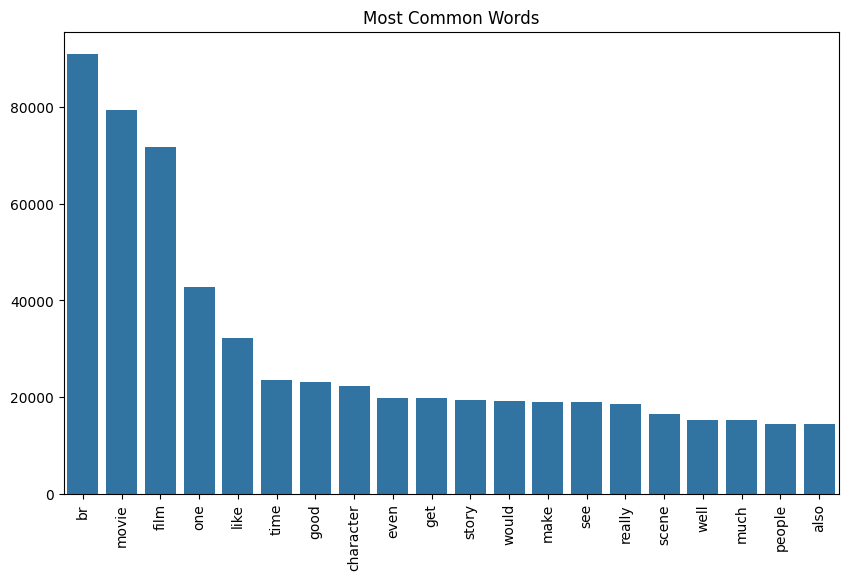

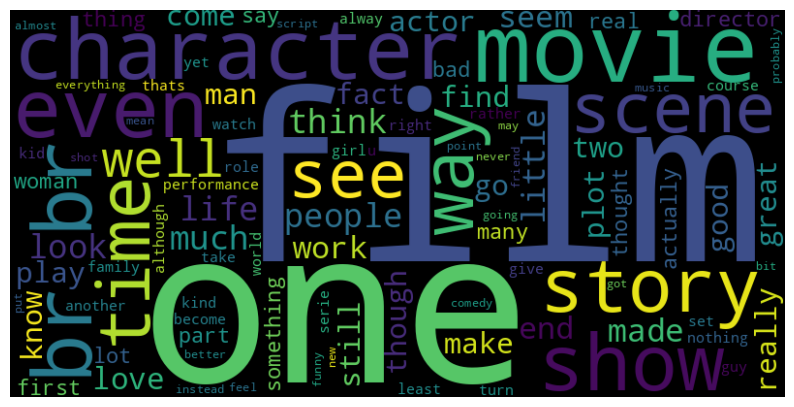

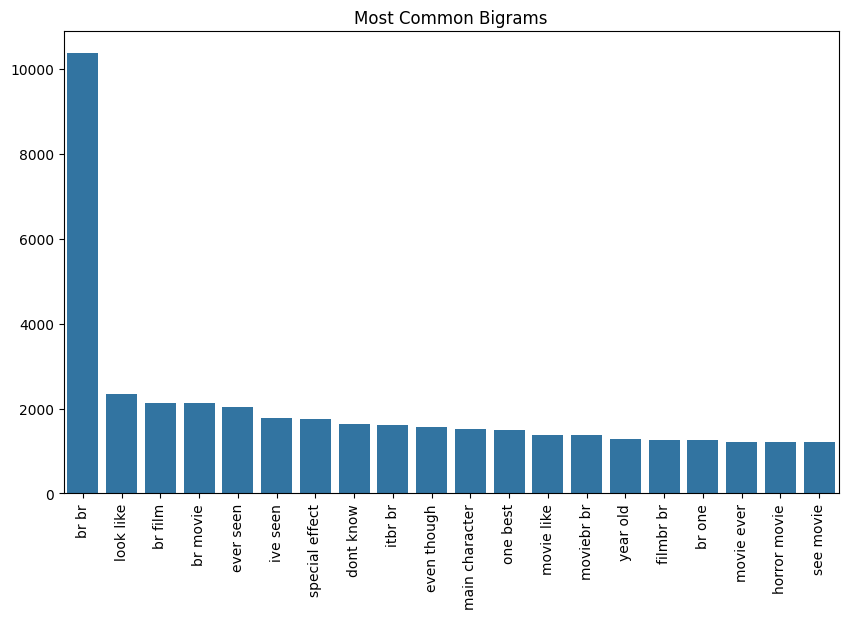

In [4]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

word_list = ' '.join(train_df['lemmatized_text']).split()
word_freq = Counter(word_list)
most_common_words = word_freq.most_common(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in most_common_words], y=[word[1] for word in most_common_words])
plt.xticks(rotation=90)
plt.title('Most Common Words')
plt.show()

wordcloud = WordCloud(width=800, height=400, max_words=100).generate(' '.join(word_list))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

bigrams = nltk.bigrams(word_list)
bigram_freq = Counter(bigrams)
most_common_bigrams = bigram_freq.most_common(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=[f"{w[0][0]} {w[0][1]}" for w in most_common_bigrams], y=[w[1] for w in most_common_bigrams])
plt.xticks(rotation=90)
plt.title('Most Common Bigrams')
plt.show()

4. Visualize the practical words that represent positive and negative sentiment in the dataset.

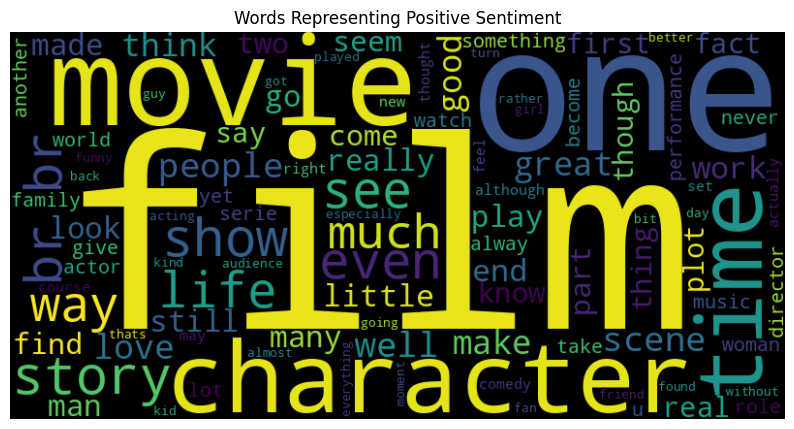

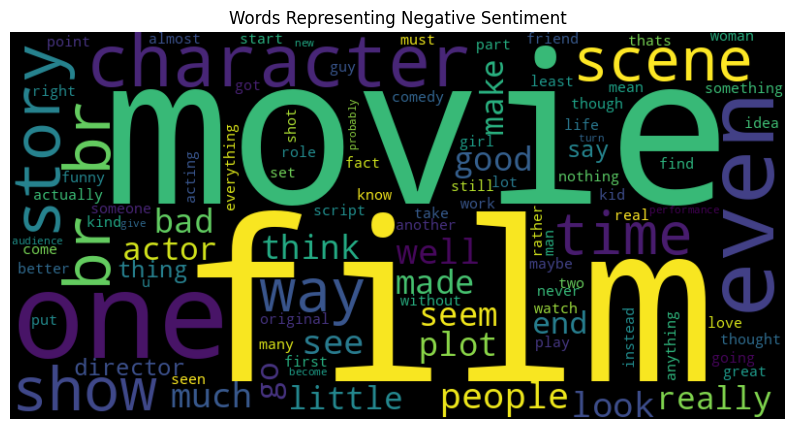

In [5]:
positive_texts = ' '.join(train_df[train_df['label'] == 1]['lemmatized_text'])
negative_texts = ' '.join(train_df[train_df['label'] == 0]['lemmatized_text'])

positive_wordcloud = WordCloud(width=800, height=400, max_words=100).generate(positive_texts)
negative_wordcloud = WordCloud(width=800, height=400, max_words=100).generate(negative_texts)

plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Words Representing Positive Sentiment')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Words Representing Negative Sentiment')
plt.axis('off')
plt.show()

5. Create an embedding layer and build the following models for predicting the sentiment:
    a. 3-layer LSTM, 
    b. 3-Layer GRU and,
    c. 4-layer Bidirectional LSTM

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_vocab_size = 10000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(train_df['lemmatized_text'])

X_train = tokenizer.texts_to_sequences(train_df['lemmatized_text'])
X_train_padded = pad_sequences(X_train, maxlen=max_sequence_length)

y_train = train_df['label']

In [8]:
#embedding layer
from tensorflow.keras.layers import Embedding
embedding_dim = 100
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)

In [9]:
#model 1: 3-Layer LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_lstm = Sequential([
    embedding_layer,
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2024-10-10 15:10:24.354867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-10 15:10:24.507178: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-10 15:10:24.507608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
#model 2: 3-Layer GRU
from tensorflow.keras.layers import GRU

model_gru = Sequential([
    embedding_layer,
    GRU(128, return_sequences=True),
    GRU(64, return_sequences=True),
    GRU(32),
    Dense(1, activation='sigmoid')
])

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
#model 3: 4-Layer Bidirectional LSTM
from tensorflow.keras.layers import Bidirectional

model_bilstm = Sequential([
    embedding_layer,
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

6. Train, Evaluate, Test the models. Plot the performance curves and tabulate accuracy. Which model 
performed the best

Epoch 1/5


2024-10-10 15:10:32.805685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-10-10 15:10:32.885122: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7da236de9100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-10 15:10:32.885143: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-10 15:10:32.905682: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-10 15:10:33.116250: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 [==============================] - 52s 50ms/step - loss: 0.3601 - accuracy: 0.8426 - val_loss: 0.3003 - val_accuracy: 0.8763
Epoch 2/5
1000/1000 [==============================] - 27s 27ms/step - loss: 0.2308 - accuracy: 0.9098 - val_loss: 0.3012 - val_accuracy: 0.8773
Epoch 3/5
1000/1000 [==============================] - 24s 24ms/step - loss: 0.1629 - accuracy: 0.9391 - val_loss: 0.3443 - val_accuracy: 0.8673
Epoch 4/5
1000/1000 [==============================] - 25s 25ms/step - loss: 0.1078 - accuracy: 0.9620 - val_loss: 0.4349 - val_accuracy: 0.8652
Epoch 5/5
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0744 - accuracy: 0.9748 - val_loss: 0.4388 - val_accuracy: 0.8710
Epoch 1/5
1000/1000 [==============================] - 41s 39ms/step - loss: 0.1466 - accuracy: 0.9455 - val_loss: 0.4387 - val_accuracy: 0.8679
Epoch 2/5
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0642 - accuracy: 0.9784 - val_loss: 0.5207 - val_accuracy: 0.

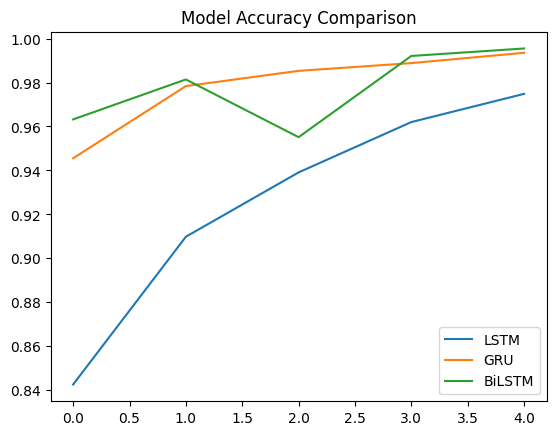

In [12]:
#plot accuracy curves
import matplotlib.pyplot as plt

history_lstm = model_lstm.fit(X_train_padded, y_train, epochs=5, validation_split=0.2)
history_gru = model_gru.fit(X_train_padded, y_train, epochs=5, validation_split=0.2)
history_bilstm = model_bilstm.fit(X_train_padded, y_train, epochs=5, validation_split=0.2)

plt.plot(history_lstm.history['accuracy'], label='LSTM')
plt.plot(history_gru.history['accuracy'], label='GRU')
plt.plot(history_bilstm.history['accuracy'], label='BiLSTM')
plt.legend()
plt.title('Model Accuracy Comparison')
plt.show()

# END